In [2]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import operator

# Introdução

Neste notebook analisamos os dados relativos aos crimes ocorridos em San Francisco e criamos modelos para prever a categoria dos crimes ocorridos. Os dados foram disponilizados no Kaggle __[aqui](https://www.kaggle.com/c/sf-crime/data)__ .

## Sumário

1. [Análise de dados](#Análise-de-dados)
2. [Predicao categoria de crime](#Predicao-categoria-de-crime)
3. [Conclusoes](#Conclusoes)

# Análise de dados

Nessa etapa, carregamos o dataset de treino baixado do Kaggle utilizando o pacote Pandas e analisamos o formato dos dados, número de instâncias e o numero de classes. Criamos também visualizações para entender melhor o comportamento temporal dos dados e a distribuicao de classes utilizando Matplotlib.

In [2]:
data_original = pd.read_csv("train_original.csv", sep=",")
data_original.shape

(878049, 9)

Percebemos que o número de instâncias é 878.049, um valor alto. Pela quantidade elevada de instâncias, é dificil utilizar um classificador como SVM, pois o dataset o treinamento demoraria muito. Desse modo, uma boa escolha de modelo a ser utilizado é o Random Forest, que utilizamos na pŕoxima seção.

In [3]:
data_original.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Os dados possuem informação espacial (atributos X e Y) e informação temporal (atributo Dates). Podemos quebrar a data em atributos como dia, mes e ano e utilizar como features categóricas em um classificador. Removemos também os atributos PdDistrict, Descript e Resolution, pois não usaremos na classificação.

In [3]:
data = pd.read_csv("train.csv", sep=",")

In [5]:
data.shape

(878049, 8)

### Dataset modificado com a data transformada em atributos

In [6]:
data.head()

,Year,Month,Day,Hour,Category,DayOfWeek,X,Y
0,2015,5,13,23,WARRANTS,Wednesday,-122.425892,37.774599
1,2015,5,13,23,OTHER OFFENSES,Wednesday,-122.425892,37.774599
2,2015,5,13,23,OTHER OFFENSES,Wednesday,-122.424363,37.800414
3,2015,5,13,23,LARCENY/THEFT,Wednesday,-122.426995,37.800873
4,2015,5,13,23,LARCENY/THEFT,Wednesday,-122.438738,37.771541


## Análise do numero de classes

O objetivo para esses dados é prever a categoria do crime, dada pelo atributo **Category**. Analisando o número de classes dos dados, podemos perceber outro desafio em relação aos dados. São numerosas classes, 39 no total, e bastante desbalanceadas, o que torna ambos undersampling e oversampling desafiadores.

In [7]:
np.unique(data["Category"])

array(['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS'], dtype=object)

In [8]:
len(np.unique(data["Category"]))

39

### Categoria de crime por numero de instancias

In [9]:
data.groupby('Category')['Category'].count().sort_values(ascending=True)

Category
TREA                                6
PORNOGRAPHY/OBSCENE MAT            22
GAMBLING                          146
SEX OFFENSES NON FORCIBLE         148
EXTORTION                         256
BRIBERY                           289
BAD CHECKS                        406
FAMILY OFFENSES                   491
SUICIDE                           508
EMBEZZLEMENT                     1166
LOITERING                        1225
ARSON                            1513
LIQUOR LAWS                      1903
RUNAWAY                          1946
DRIVING UNDER THE INFLUENCE      2268
KIDNAPPING                       2341
RECOVERED VEHICLE                3138
DRUNKENNESS                      4280
DISORDERLY CONDUCT               4320
SEX OFFENSES FORCIBLE            4388
STOLEN PROPERTY                  4540
TRESPASS                         7326
PROSTITUTION                     7484
WEAPON LAWS                      8555
SECONDARY CODES                  9985
FORGERY/COUNTERFEITING          10609
FRA

### Pie chart de categorias de crime

Para visualizar a distribuição de tipos de crime, podemos fazer um Pie Chart. Esse gráfico ilustra a frequência de cada crime em todo dataset. Foram escolhidos os 9 crimes mais frequentes e o restante é representado pela categoria **EVERYTHING ELSE**.

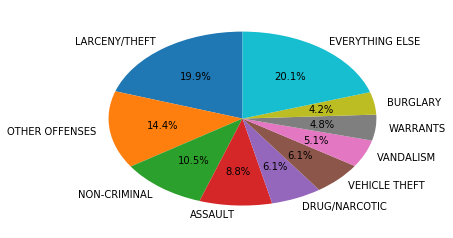

In [36]:
count = Counter(data.Category)
key = sorted(count, key=count.__getitem__, reverse=True)
value = sorted(count.values(), reverse=True)

labels = key[:9]
labels.append("EVERYTHING ELSE")
frequency = value[:9]
frequency.append(sum(value[9:]))

plt.pie(frequency, labels=labels, startangle=90, autopct='%.1f%%')
plt.show()

## Análise temporal

Pode-se analisar a distribuição temporal dos dados criando gráficos de barra empilhados por categoria de crime para ano, mês, dia da semana e hora.

### Análise de categoria de crimes por ano

Verifica-se que a quantidade de crimes cometidos oscilou pouco, ocorrendo uma leve redução entre os anos 2003 e 2011. Em 2013, porém, registrou-se o maior número de crimes comparados aos últimos anos. Em 2015, os crimes foram registrados até o mês de maio, o que tornou a análise incompleta para o mesmo ano.

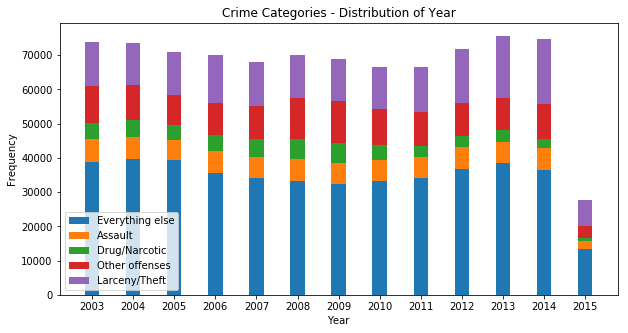

In [38]:
list_years = np.sort(data.Year.unique())

larceny = []
other = []
narcotic = []
assault = []
eelse = []

for i in list_years:
    count = Counter(data.Category.loc[data.Year == i])
    value = sorted(count.values(), reverse=True)
    larceny.append(count.get("LARCENY/THEFT"))
    other.append(count.get("OTHER OFFENSES"))
    narcotic.append(count.get("DRUG/NARCOTIC"))
    assault.append(count.get("ASSAULT"))
    eelse.append(sum(value) - larceny[-1] - other[-1] - narcotic[-1] - assault[-1])

N = len(list_years)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.figure(figsize = (10,5))

p1 = plt.bar(ind, eelse, width)
p2 = plt.bar(ind, assault, width, bottom = eelse)
p3 = plt.bar(ind, narcotic, width, bottom = list(np.array(eelse) + np.array(assault)))
p4 = plt.bar(ind, other, width, bottom = list(np.array(eelse) + np.array(assault) + np.array(narcotic)))
p5 = plt.bar(ind, larceny, width, bottom = list(np.array(eelse) + np.array(assault) + np.array(narcotic) + np.array(other)))

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Crime Categories - Distribution of Year')
plt.xticks(ind, list_years)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Everything else', 'Assault', 'Drug/Narcotic', 'Other offenses', 'Larceny/Theft'), loc='lower left')

plt.show()

### Análise de categoria de crimes por hora do dia

Verifica-se que o tipo de crime cometido varia bastante ao longo do dia em comparação a variação anual, que é mais suave. 
Em determinadas horas do dia, "outras ofensas" torna-se mais frequente do que "furtos/roubos". 
O horário "pico" de crimes são às 18 h.



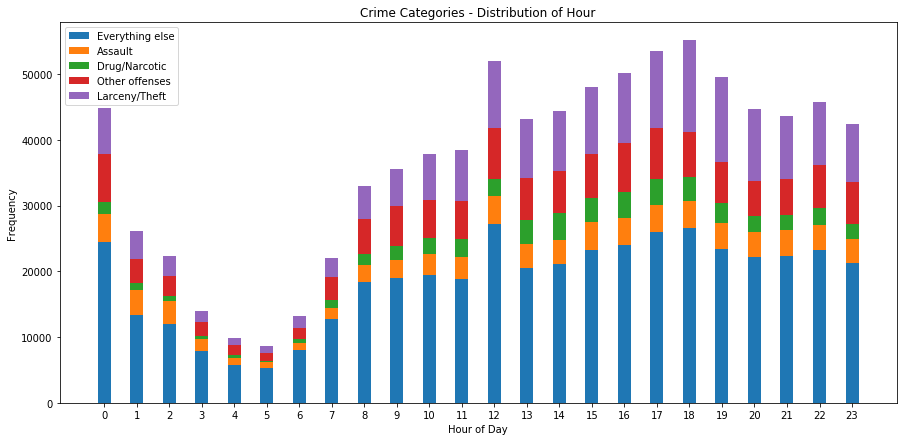

In [44]:
list_hour = np.sort(data.Hour.unique())

larceny = []
other = []
narcotic = []
assault = []
eelse = []

for h in list_hour:
    count = Counter(data.Category.loc[data.Hour == h])
    value = sorted(count.values(), reverse=True)
    larceny.append(count.get("LARCENY/THEFT"))
    other.append(count.get("OTHER OFFENSES"))
    narcotic.append(count.get("DRUG/NARCOTIC"))
    assault.append(count.get("ASSAULT"))
    eelse.append(sum(value) - larceny[-1] - other[-1] - narcotic[-1] - assault[-1])
    
N = len(list_hour)

ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

plt.figure(figsize = (15,7))

p1 = plt.bar(ind, eelse, width)
p2 = plt.bar(ind, assault, width, bottom = eelse)
p3 = plt.bar(ind, narcotic, width, bottom = list(np.array(eelse) + np.array(assault)))
p4 = plt.bar(ind, other, width, bottom = list(np.array(eelse) + np.array(assault) + np.array(narcotic)))
p5 = plt.bar(ind, larceny, width, bottom = list(np.array(eelse) + np.array(assault) + np.array(narcotic) + np.array(other)))

plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Crime Categories - Distribution of Hour')
plt.xticks(ind, list_hour)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Everything else', 'Assault', 'Drug/Narcotic', 'Other offenses', 'Larceny/Theft'), loc='upper left')

plt.show()

# Predicao categoria de crime

## Utilizando coordenadas X e Y

Primeiramente, treinamos Random Forest apenas nos dados de localizacao (atributos X e Y) com um esquema de divisão 80% treino 20% teste, feitos estratificadamente para manter a distribuicao das classes.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[["X","Y"]], data["Category"], test_size=0.2, stratify=data['Category'])
scaler = MinMaxScaler()

In [5]:
clf = make_pipeline(MinMaxScaler(), RandomForestClassifier(n_estimators=150, n_jobs=2))

In [6]:
clf.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

### Log Loss

A métrica de desempenho utilizada na competição é o Log Loss. Essa métrica é definida pela log-probabilidade negativa dos rótulos verdadeiros dadas as previsões de um classificador probabilístico. Desse modo, para calculá-la, utilizamos como saída do classificador as probabilidades previstas para cada instância de teste.

In [ ]:
pred = clf.predict_proba(X_test)

In [14]:
pred.shape

(175610, 39)

In [15]:
log_loss(y_test, pred)

2.5838000471708034

### Ajustando parâmetros

Como não sabemos os melhores parametros para o modelo, iremos ajustá-lo no esquema 3-fold cross validation utilizando busca em grid. Primeiramente utilizaremos apenas os dados das coordenadas X e Y. O pipeline que  implementamos na classe ClassifierPipeline, aplica scaling de 0 a 1 nos dados das coordenadas e uma busca em grid para os parametros do classificador desejado. É importante ressaltar que a saída da função é o log loss negado porque a busca em grid sempre maximiza o valor do score por default, portanto valores que devem ser minimizados possuem seus valores negados.

In [16]:
from model_tuning import ClassifierPipeline

Esse processo demora certo tempo, pois o banco é muito grande e várias combinações estão sendo testadas. Nos é retornada a melhor combinação de parâmetros do grid colocado. O resultado foi um pouco melhor do que o parâmetro que colocamos na divisao 80/20.

In [17]:
rf_parameters = {
        "n_estimators":[150, 200, 250],
        "max_depth": [10,15,20]
}
pipeline = ClassifierPipeline(RandomForestClassifier(), rf_parameters, n_jobs=2)
pipeline.fit(data[["X","Y"]], data["Category"])


Best score: -2.478
Best parameters set:
	clf__max_depth: 10
	clf__n_estimators: 250


É possivel também visualizar os resultados para cada combinação desejada.

In [18]:
pipeline.get_cv_results()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,107.001906,0.843753,14.374518,0.039568,10,150,"{'clf__max_depth': 10, 'clf__n_estimators': 150}",-2.506033,-2.448943,-2.483142,-2.479373,0.023459,3
1,140.700231,1.172925,18.863728,0.183730,10,200,"{'clf__max_depth': 10, 'clf__n_estimators': 200}",-2.506696,-2.447674,-2.484952,-2.479775,0.024372,4
2,175.722402,1.478251,23.556669,0.428332,10,250,"{'clf__max_depth': 10, 'clf__n_estimators': 250}",-2.505753,-2.448543,-2.480879,-2.478392,0.023422,1
3,121.343305,1.389591,17.369820,0.502810,15,150,"{'clf__max_depth': 15, 'clf__n_estimators': 150}",-2.515952,-2.433258,-2.505791,-2.485001,0.036822,6
4,160.164636,0.602939,22.831981,0.435058,15,200,"{'clf__max_depth': 15, 'clf__n_estimators': 200}",-2.515615,-2.429887,-2.498634,-2.481379,0.037064,5
5,204.226629,3.761786,30.541275,1.958017,15,250,"{'clf__max_depth': 15, 'clf__n_estimators': 250}",-2.511040,-2.429340,-2.496182,-2.478854,0.035534,2
6,128.117592,3.876016,19.788930,0.124079,20,150,"{'clf__max_depth': 20, 'clf__n_estimators': 150}",-2.835732,-2.670048,-2.788839,-2.764874,0.069731,9
7,169.841316,2.587281,25.984079,0.217235,20,200,"{'clf__max_depth': 20, 'clf__n_estimators': 200}",-2.803182,-2.654783,-2.760485,-2.739484,0.062377,8
8,209.408009,2.666703,32.485311,2.662955,20,250,"{'clf__max_depth': 20, 'clf__n_estimators': 250}",-2.788637,-2.638065,-2.739939,-2.722215,0.062736,7


## Utilizando Dia da Semana, Mês e Coordenadas
Agora, utilizaremos também os dados temporais. Para isso, temos que transformar as colunas categóricas para numéricas, no caso utilizaremos inicialmente dia da semana e mês.

In [47]:
tempdf = data[['Category','DayOfWeek', 'Month', 'X', 'Y']]
tempdf.head()

,Category,DayOfWeek,Month,X,Y
0,WARRANTS,Wednesday,5,-122.425892,37.774599
1,OTHER OFFENSES,Wednesday,5,-122.425892,37.774599
2,OTHER OFFENSES,Wednesday,5,-122.424363,37.800414
3,LARCENY/THEFT,Wednesday,5,-122.426995,37.800873
4,LARCENY/THEFT,Wednesday,5,-122.438738,37.771541


Binarizando as features categoricas utilizando uma funcao de pandas.

In [48]:
df = pd.get_dummies(tempdf, columns=['Month', 'DayOfWeek'])
df.head()

,Category,X,Y,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Month_10,Month_11,Month_12,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,WARRANTS,-122.425892,37.774599,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,OTHER OFFENSES,-122.425892,37.774599,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,OTHER OFFENSES,-122.424363,37.800414,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,LARCENY/THEFT,-122.426995,37.800873,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,LARCENY/THEFT,-122.438738,37.771541,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Ajustando parametros
Fazendo busca em grid para os melhores parametros.

In [22]:
rf_parameters = {
        "n_estimators":[250, 300],
        "max_depth": [5,10]
}
pipeline = ClassifierPipeline(RandomForestClassifier(), rf_parameters, n_jobs=2)
pipeline.fit(df.drop(columns=["Category"]), df['Category'])

Best score: -2.580
Best parameters set:
	clf__max_depth: 10
	clf__n_estimators: 300


## Utilizando dia da semana e coordenadas

O resultado nao melhorou adicionando mes e dia da semana. Vamos tentar utilizar apenas dia da semana.

In [28]:
tempdf = data[['Category','DayOfWeek', 'X', 'Y']]
tempdf.head()

,Category,DayOfWeek,X,Y
0,WARRANTS,Wednesday,-122.425892,37.774599
1,OTHER OFFENSES,Wednesday,-122.425892,37.774599
2,OTHER OFFENSES,Wednesday,-122.424363,37.800414
3,LARCENY/THEFT,Wednesday,-122.426995,37.800873
4,LARCENY/THEFT,Wednesday,-122.438738,37.771541


In [29]:
df = pd.get_dummies(tempdf, columns=['DayOfWeek'])
rf_parameters = {
        "n_estimators":[250, 300],
        "max_depth": [5,10]
}
pipeline = ClassifierPipeline(RandomForestClassifier(), rf_parameters, n_jobs=2)
pipeline.fit(df.drop(columns=["Category"]), df['Category'])


Best score: -2.522
Best parameters set:
	clf__max_depth: 10
	clf__n_estimators: 250


## Utilizando hora e coordenadas

E por ultimo, utilizando apenas hora e coordenadas.

In [31]:
tempdf = data[['Category','Hour', 'X', 'Y']]
tempdf.head()

,Category,Hour,X,Y
0,WARRANTS,23,-122.425892,37.774599
1,OTHER OFFENSES,23,-122.425892,37.774599
2,OTHER OFFENSES,23,-122.424363,37.800414
3,LARCENY/THEFT,23,-122.426995,37.800873
4,LARCENY/THEFT,23,-122.438738,37.771541


In [32]:
df = pd.get_dummies(tempdf, columns=['Hour'])
rf_parameters = {
        "n_estimators":[250, 300],
        "max_depth": [5,10]
}
pipeline = ClassifierPipeline(RandomForestClassifier(), rf_parameters, n_jobs=2)
pipeline.fit(df.drop(columns=["Category"]), df['Category'])

Best score: -2.547
Best parameters set:
	clf__max_depth: 10
	clf__n_estimators: 300


# Conclusões

Observamos que o melhor resultado foi obtido sem considerar os dados temporais. Isso indica a necessidade de investigar modelos que considerem a ordem temporal dos dados para que os padrões de variações temporais sejam detectados. Apesar do banco ser bastante grande, foi possivel treinar o modelo random forest e obter uma melhora de performance quando os parâmetros do modelo foram ajustados.